In [ ]:
# On Colab, you can uncomment the line below to install the required packages.
# !pip install networkx pandas numpy matplotlib seaborn scipy

# Clone the repo (to get access to the module)
#!git clone https://github.com/jgarciab/NetworkScience.git
#import sys
#sys.path.append('/content/NetworkScience/Practicals/day1/')


In [ ]:
# on your computer
path_data = "../../Data/"

# on colab uncomment the line below
# path_data = "/content/NetworkScience/Data/"

# Matrix Multiplication and Centrality in Networks

Welcome to the afternoon practical! In this session, you'll learn how to represent networks as matrices, perform matrix operations, and compute node centrality measures.

**Learning objectives:**
- Understand different ways to represent a network (adjacency matrix, edgelist, etc.)
- Practice converting between representations
- Use matrix multiplication to explore paths and clustering
- Calculate and interpret centrality measures

Each section contains explanations, code, and exercises. Read the explanations and comments before running the code.

In [ ]:
# Import network analysis libraries
import networkx as nx  # For network analysis

# Import data processing libraries
import pandas as pd    # For data manipulation
import numpy as np     # For numerical operations

# Import utility functions from local file
import sys
sys.path.append("./")
from common_functions import *  # Custom helper functions

# Import visualization libraries
import pylab as plt
import matplotlib as mpl
import seaborn as sns

# Set custom visualization parameters for better aesthetics
custom_params = {
    'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.left': False, 'axes.spines.bottom': False,
    'lines.linewidth': 2, 'grid.color': 'lightgray', 'legend.frameon': False,
    'xtick.labelcolor': '#484848', 'ytick.labelcolor': '#484848',
    'xtick.color': '#484848', 'ytick.color': '#484848',
    'text.color': '#484848', 'axes.labelcolor': '#484848',
    'axes.titlecolor':'#484848', 'figure.figsize': [5,3],
    'axes.titlelocation':'left',
    'xaxis.labellocation':'left',
    'yaxis.labellocation':'bottom'
}
# Define a color palette for plots
palette = ['#3d348b','#e6af2e','#191716','#e0e2db']  # Custom color palette
sns.set_theme(context='paper', style='white', palette=palette, font_scale=1.3, color_codes=True, rc=custom_params)

# Widen the notebook display for better plot visibility
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
# --- Helper Functions for Visualization and Conversion ---
# These functions help plot networks, adjacency matrices, and convert between representations.

def plot_network(G, a0 = None, values = None):
    """
    Plots network with nice defaults.
    Node color and size can be set by 'values' (e.g., centrality).
    """
    if values is None:
        values = nx.degree_centrality(G).values()
    if a0 is None:
        fig, a0 = plt.subplots()
    norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values), clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    mapper._A = []
    cb = plt.colorbar(mapper, ax = a0, location="bottom", shrink=0.8, pad = 0.02, label = "Value")
    cb.outline.set_visible(False)

    # Draw network layout
    if nx.is_bipartite(G):
        top = [_ for _ in G.nodes() if _[0] != "S"]
        pos = nx.bipartite_layout(G, top)
        node_color = ["#e6af2e" if node in top else "#e0e2db" for node in G]
    else:
        pos = nx.spring_layout(G, seed = 1)
        node_color = [mapper.to_rgba(i) for i in values]

    nx.draw(G, pos = pos, with_labels = True, node_size=500*np.array(list(values)), edge_color = "darkgray", 
           node_color = node_color, ax = a0)
    

def plot_network_adj(G, values = None):
    """
    Plots the graph (with color/node size adjusted according to values) and the adjacency matrix.
    Shows both the network and its matrix representation side by side.
    """
    f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 0.5]}, figsize=(12,4))
    
    # Plot network
    plot_network(G, a0, values = values)
    
    # Show adjacency table
    df = nx.to_pandas_adjacency(G, nodelist=list(G.nodes()), dtype=int)
    plot_table(a1, df.values, df.index, df.columns)

    A = nx.to_scipy_sparse_array(G, nodelist=list(G.nodes()), weight=1)
    N = len(G.nodes())
    
    # Plot table as a heatmap
    a2.spy(A)
    sns.despine(bottom="True", left=True)
    plt.grid(True)
    a2.set_xticks(range(N), G.nodes(), rotation=90)
    a2.set_yticks(range(N), G.nodes())
    
    plt.tight_layout()

def plot_table(a1, cellText, rowLabels, colLabels):
    """
    Plots a table in a figure. Highlights cells with edges.
    """
    cellText = pd.DataFrame(cellText)
    the_table = a1.table(cellText=cellText.values, rowLabels=rowLabels, colLabels=colLabels, loc='center', colLoc = "left", cellColours=(cellText>0).replace({False: "white", True:"#e6af2e"}).values)
    a1.axis(False) 
    the_table.scale(0.8, 1.6)

def adj_to_net(A, d_names = {0: "Alice", 1: "Bob", 2: "John", 3:"Amy", 4:"Mike", 5:"Rose"}):
    """
    Create graph from adjacency matrix, rename nodes for clarity.
    """
    G = nx.from_numpy_array(A, create_using=nx.DiGraph())
    G = nx.relabel_nodes(G, d_names)
    return G



# Let's start creating and visualizing an example network

We'll create small example networks to see how matrix representations work.

Note the `create_using` parameter. Why is it needed?

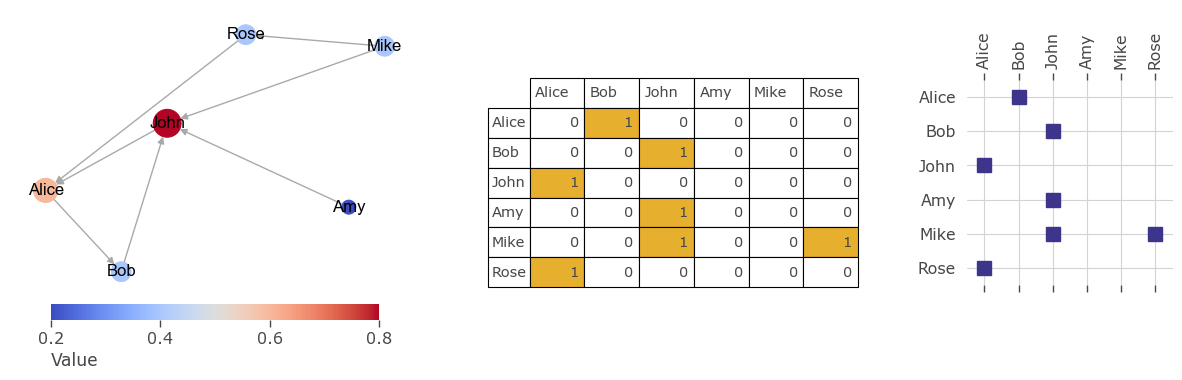

In [5]:
# --- Create and Visualize Example Networks ---
# We'll create small example networks to see how matrix representations work.
#
# Note: The 'create_using' parameter specifies if the network is directed or undirected.

# Small directed network to understand matrix multiplication
G_dir = nx.from_edgelist([
    ("Alice", "Bob"),
    ("John", "Alice"),
    ("Bob", "John"),
    ("Amy", "John"),
    ("Mike", "John"),
    ("Rose", "Alice"),
    ("Mike", "Rose")
], create_using=nx.DiGraph())

# Visualize the directed network and its adjacency matrix
plot_network_adj(G_dir)

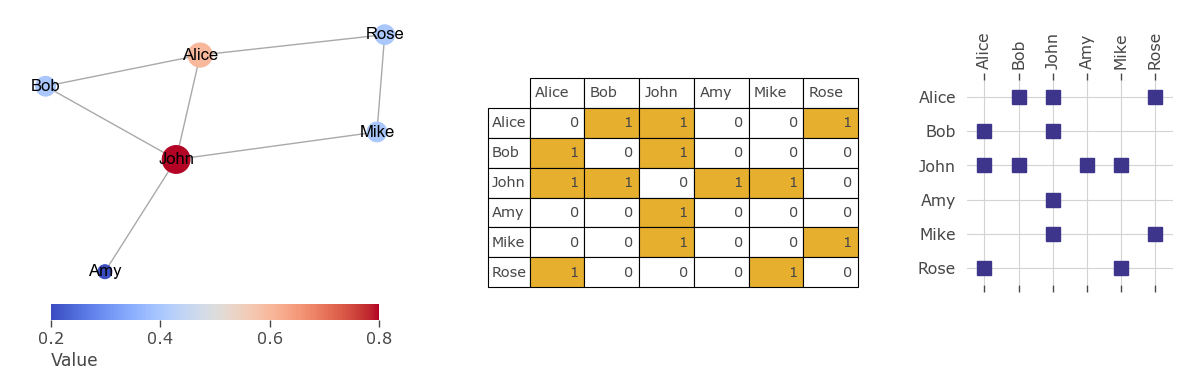

In [6]:
# --- Create and Visualize an Undirected Network ---
# This network has the same edges as above, but is undirected.
#
G_undir = nx.from_edgelist([
    ("Alice", "Bob"),
    ("John", "Alice"),
    ("Bob", "John"),
    ("Amy", "John"),
    ("Mike", "John"),
    ("Rose", "Alice"),
    ("Mike", "Rose")
], create_using=nx.Graph())

# Visualize the undirected network and its adjacency matrix
plot_network_adj(G_undir)

In [7]:
# --- Add Node Metadata (Attributes) ---
# Here we create a DataFrame with the number of children for each person.
# This metadata will be used later for matrix operations.

df = pd.DataFrame([["Alice", 2],
                  ["Bob",    0],
                  ["John",   2],
                  ["Amy",    0],
                  ["Mike",   1],
                  ["Rose",   5]], 
                  columns=["person","children"])

df  # Display the metadata table

,person,children
0,Alice,2
1,Bob,0
2,John,2
3,Amy,0
4,Mike,1
5,Rose,5


# Exercise 1: Network representations

**Goal:** Compare different ways to represent matrices and convert between them.

We'll use the `G_dir` network for these tasks.

## 1.1 Convert the directed network to different formats
- `numpy_array`: Fast, good for numerical operations.
- `scipy_sparse_array`: Efficient for large, sparse networks.
- `pandas_adjacency`: Easy to inspect as a table.
- `pandas_edgelist`: Good for data manipulation and import/export.

Use the `nx.to_...` functions. What are the advantages of each?

In [ ]:
# Example to convert the network to a sparse adjacency matrix
A = nx.to_scipy_sparse_array(G_dir, nodelist=list(G_dir.nodes()), weight=1)
print(A)

## Convert to other formats

<Compressed Sparse Row sparse array of dtype 'int64'
	with 7 stored elements and shape (6, 6)>

### 1.2 Visualize the adjacency matrix
Use `plt.spy()` to see the structure of the adjacency matrix. Nonzero entries indicate edges.

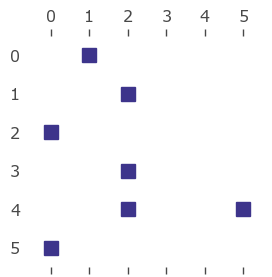

In [9]:
# Visualize the sparse adjacency matrix using a spy plot
A = nx.to_scipy_sparse_array(G_dir, nodelist=list(G_dir.nodes()), weight=1)
plt.spy(A)

## 1.3 Create a network from an edgelist

Convert a pandas edgelist back to a graph. This is useful for importing/exporting network data.

In [10]:
# Starting from an edgelist 
df_edg = nx.to_pandas_edgelist(G_dir, nodelist=list(G_dir.nodes()))
df_edg.head()

,source,target
0,Alice,Bob
1,Bob,John
2,John,Alice
3,Amy,John
4,Mike,John


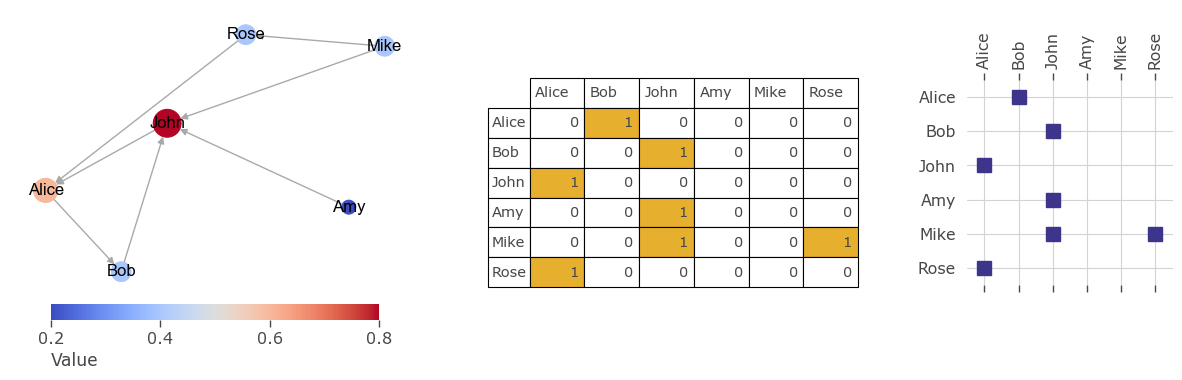

In [11]:
# Convert to graph and plot
G = nx.from_pandas_edgelist(df_edg, create_using=nx.DiGraph())

plot_network_adj(G)

## 1.4 Create a network from an adjacency matrix

Convert a matrix back to a graph. Remember to relabel nodes if needed.

In [12]:
# Convert the following adjacency matrix
A = np.array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]])

# Translation between index and names
d_names = {0: 'Alice', 1: 'Bob', 2: 'John', 3: 'Amy', 4: 'Mike', 5: 'Rose'}
A

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]])

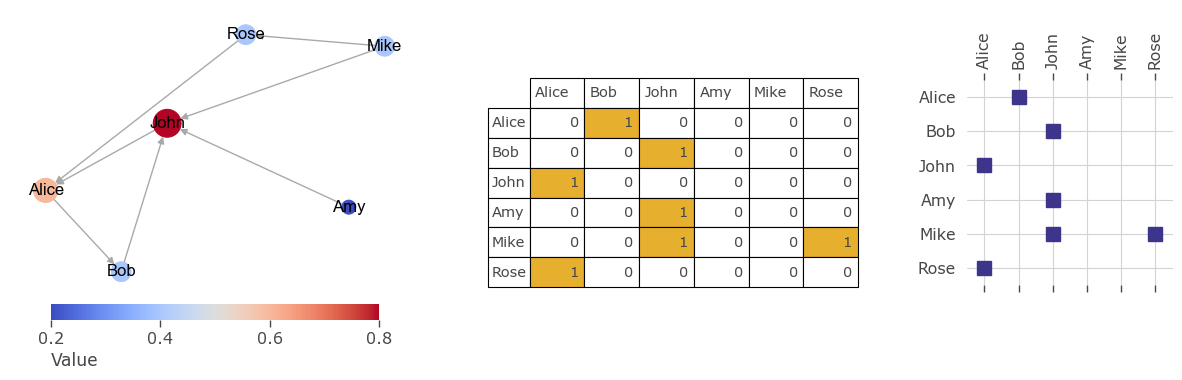

In [ ]:
# Convert to graph
G = ...
# Add labels
G = nx.relabel_nodes(G, d_names) 
# Plot
plot_network_adj(G)

# Exercise 2: Matrix multiplication = combining the attributes of the neighbors

**Question:** What is the average number of children of your friends?
- Use matrix multiplication (`@`) to sum the children of each node's neighbors.
- Divide by the number of neighbors to get the average.
- Visualize the result on the network.

In python
* Matrix multiplication (dot-product) is done using `@` (e.g. A @ B)
    * The number of columns of A needs to match the number of rows of B!
* Element-wise multiplication is done using `*` (e.g. A*B multiplies the element i,j of A with the element i,j of B)
    * If B is a matrix (==array), the dimensions need to match those of A
    * If B is a vector, it multiplies it row-wise (the number of rows of A need to match the number of elements of B)



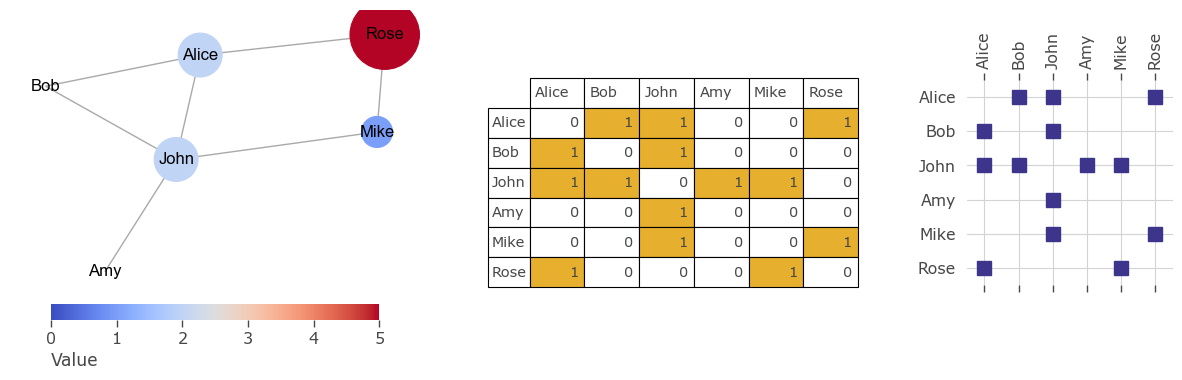

In [14]:
# Original network adding the children as a color/size
plot_network_adj(G_undir, values = df["children"])

[7 4 3 2 7 3]


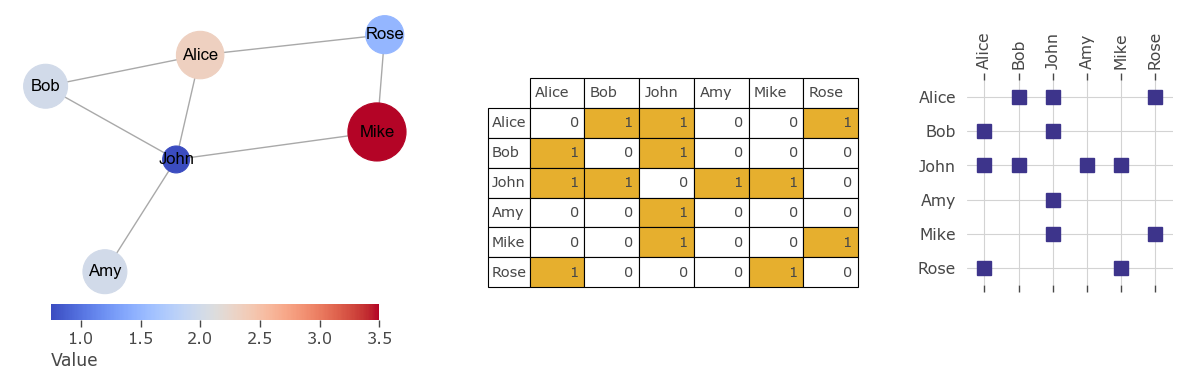

In [ ]:
# adjacency array
A = nx.to_scipy_sparse_array(G_undir)


In [ ]:
# Calculate sum of neighbors children
sum_children = ...

In [ ]:
# Divide by number of neighbors to get an average
avg_children = sum_children / ...


In [ ]:
print(sum_children)
plot_network_adj(G_undir, values=avg_children)

# Exercise 3: Matrix multiplication and paths

## 3a. Number of paths
- The adjacency matrix to the power of n (`A^n`) gives the number of paths of length n between nodes.
- Use this to find nodes 2 or 3 steps away.

## 3b. Triangles and clustering
- The diagonal of `A^3` counts triangles.
- For undirected networks, divide by 2; for directed, use as is.
- Compare with NetworkX's built-in clustering.

## Exercise 3a: Matrix multiplication and paths

One step away
Two steps away
Three steps away. Triangles!


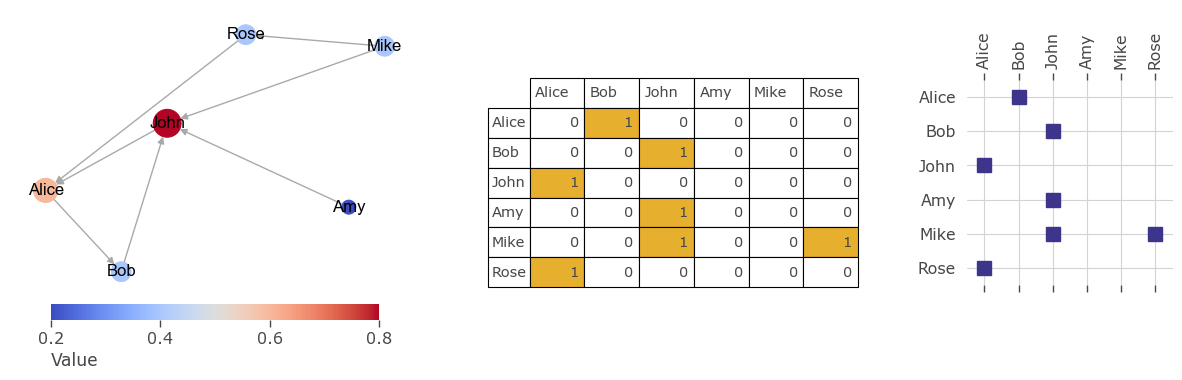

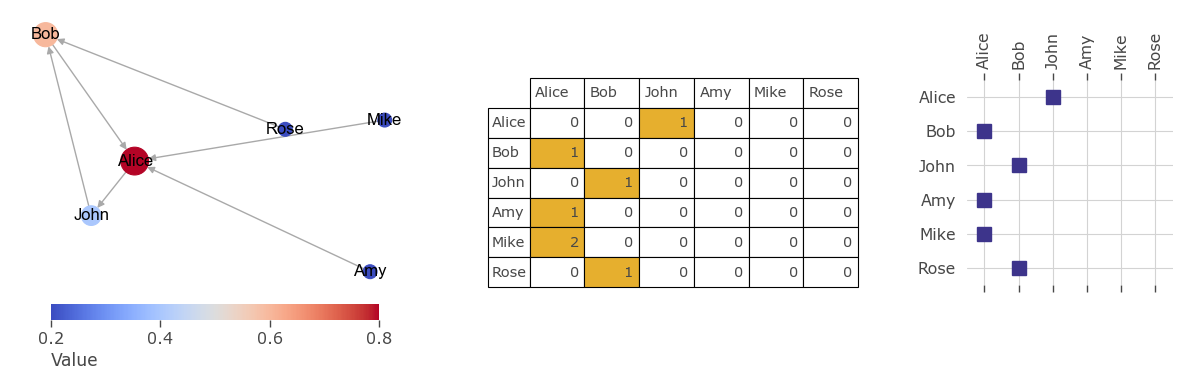

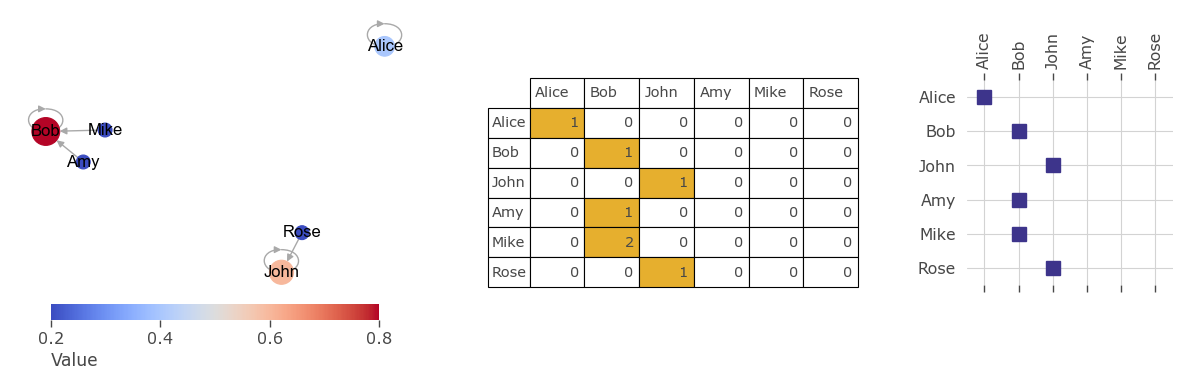

In [16]:
# Number of paths to go from node i to node j in x steps

# Find who is one step away (just the normal adjacency matrix)
print("One step away")
plot_network_adj(G_dir)
A = nx.to_scipy_sparse_array(G_dir)

# Find who is two steps away
print("Two steps away")
G2 = adj_to_net(A @ A) #A**2
plot_network_adj(G2)

# Find who is three steps away
print("Three steps away. Triangles!")
G3 = adj_to_net(A @ A @ A) #A**3
plot_network_adj(G3)



In [ ]:
# Number of nodes reached in 1, 2 or 3 steps
M = ...
M = M > 0 # Do not count people several times
M.setdiag(0) # do not count yourself
M.todense().sum(1)

array([2, 2, 2, 3, 4, 3])

## Exercise 3b: Number of triangles and clustering

[('Alice', np.int64(1)),
 ('Bob', np.int64(1)),
 ('John', np.int64(1)),
 ('Amy', np.int64(0)),
 ('Mike', np.int64(0)),
 ('Rose', np.int64(0))]

1.0


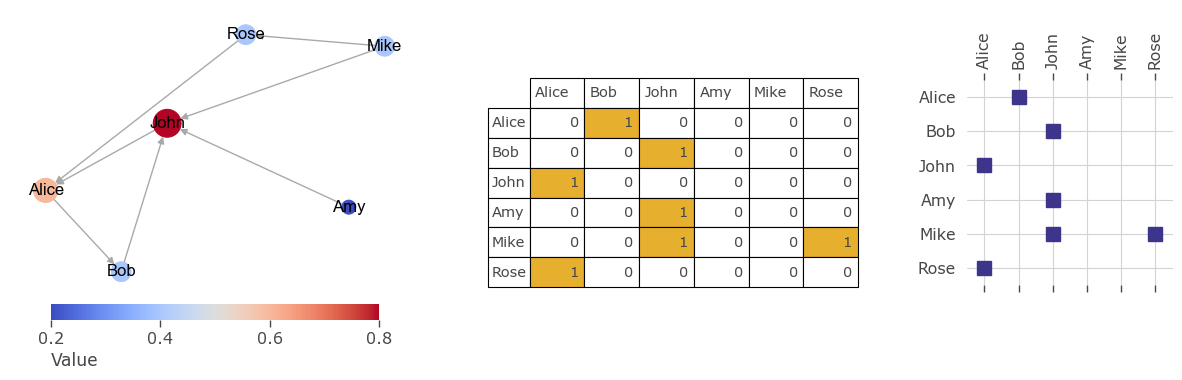

In [ ]:
# Count number of triangles in the directed network
plot_network_adj(G_dir)
A = nx.to_scipy_sparse_array(G_dir)
path_3 = ...

# For undirected newtorks there are two directions, for directed networks one
display(list(zip(G_dir.nodes(), path_3.diagonal() )))

# Number of triangles = trace / 3 (each  triangle count in 3 nodes)
print(path_3.trace()/3)

[('Alice', np.float64(1.0)),
 ('Bob', np.float64(1.0)),
 ('John', np.float64(1.0)),
 ('Amy', np.float64(0.0)),
 ('Mike', np.float64(0.0)),
 ('Rose', np.float64(0.0))]

1.0


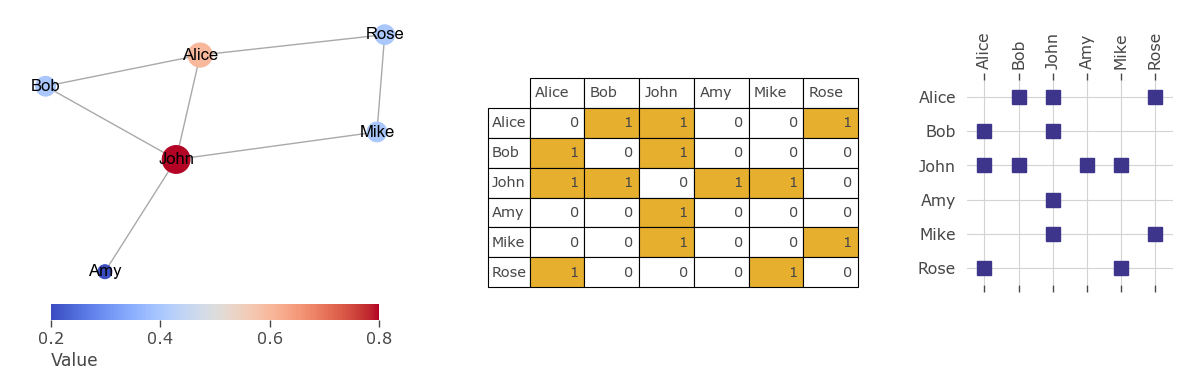

In [ ]:
# Count number of triangles in the undirected network
plot_network_adj(G_undir)
A = nx.to_scipy_sparse_array(G_undir)
path_3 = A @ A @ A


# For undirected newtorks there are two directions
display(list(zip(G_undir.nodes(), path_3.diagonal() / 2)))

# Number of triangles = trace / 6 (each  triangle count in 3 nodes, each triangle counted in two directions)
print(...)

In [20]:
# Local clustering = number of triangles / number of potential links
print(nx.clustering(G_undir)) #standard nx function
A = nx.to_scipy_sparse_array(G_undir)

# Number of triangles
path_3 = (A@A@A).diagonal()/2 # divided by two because there are two directions

# Number of potential links between neighbors
degree = A.sum(1)
potential_links = (degree*(degree-1)/2)

pd.DataFrame(zip(G_undir.nodes(), 
         path_3, 
         potential_links, 
         path_3/potential_links,
         nx.clustering(G_undir).values()
        ),
        columns=["Node", "Triangles", "Potential links", "Clustering coefficient", "Clustering coefficient (nx)"]
    )

{'Alice': 0.3333333333333333, 'Bob': 1.0, 'John': 0.16666666666666666, 'Amy': 0, 'Mike': 0, 'Rose': 0}


/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_30418/3797362239.py:15: RuntimeWarning: invalid value encountered in divide
  path_3/potential_links,


,Node,Triangles,Potential links,Clustering coefficient,Clustering coefficient (nx)
0,Alice,1.0,3.0,0.333333,0.333333
1,Bob,1.0,1.0,1.000000,1.000000
2,John,1.0,6.0,0.166667,0.166667
3,Amy,0.0,0.0,NaN,0.000000
4,Mike,0.0,1.0,0.000000,0.000000
5,Rose,0.0,1.0,0.000000,0.000000


---

# Exercise 4: Node centrality

Centrality measures help identify important nodes.
- **Degree:** Number of connections
- **Closeness:** Inverse of average distance to all others
- **Betweenness:** Fraction of shortest paths passing through
- **Eigenvector:** Influence based on neighbors' importance
- **Pagerank:** Like eigenvector, but for directed networks
- **Katz, HITS:** Other advanced measures

Use `plot_network_distribution` to visualize centrality as node color.

In [21]:
# Load example graph
G = nx.florentine_families_graph()

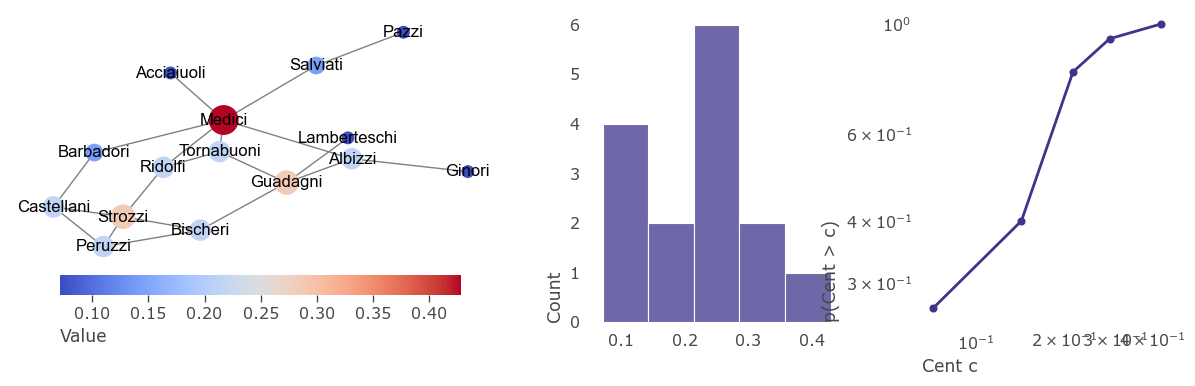

In [22]:
# Degree centrality
cent = nx.degree_centrality(G) 
cent = [cent[node] for node in G.nodes()]

plot_network_distribution(G, cent)

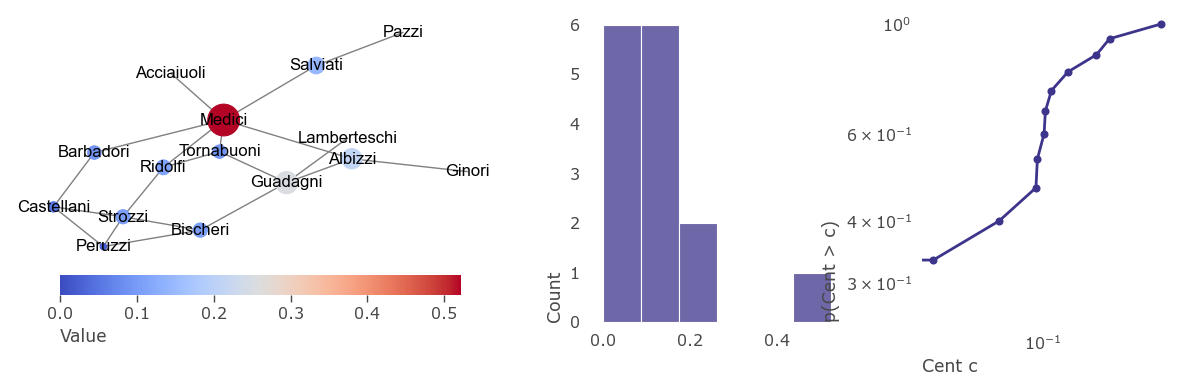

In [ ]:
# Betweeness centrality
cent = ...
cent = [cent[node] for node in G.nodes()]

plot_network_distribution(G, cent)

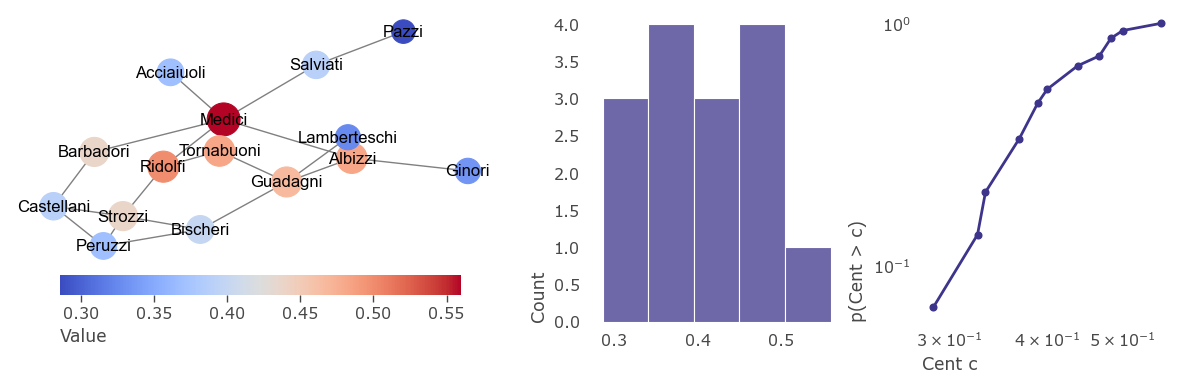

In [ ]:
# Closeness centrality
cent = ...
cent = [cent[node] for node in G.nodes()]

plot_network_distribution(G, cent)

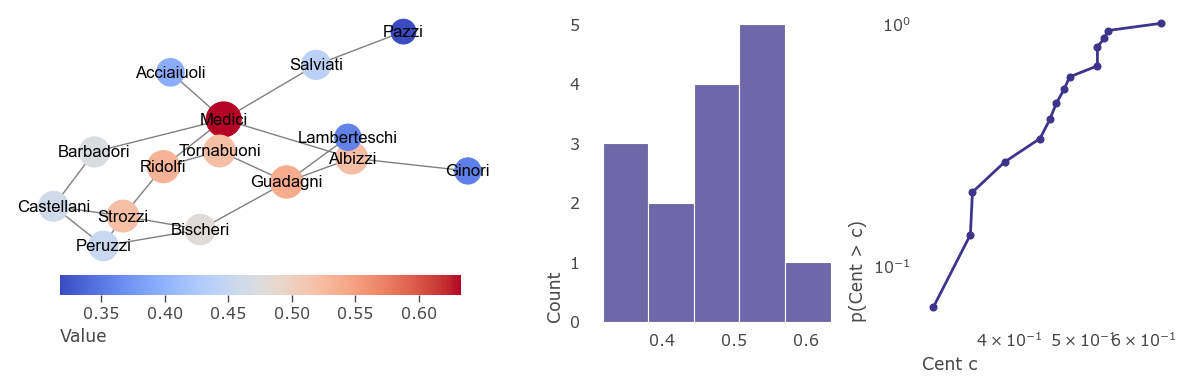

In [ ]:
# Harmonic centrality
cent = ...
cent = [cent[node]/15 for node in G.nodes()]

plot_network_distribution(G, cent)

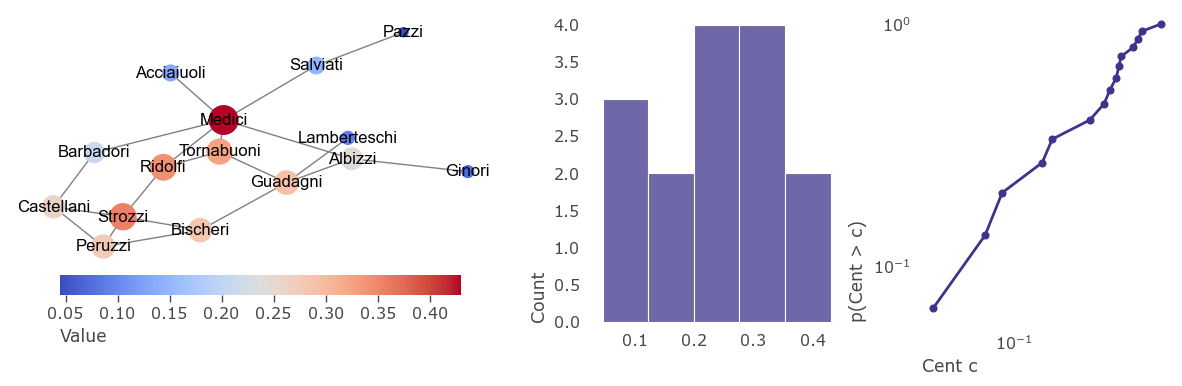

In [ ]:
# Eigenvector centrality
cent = ...
cent = [cent[node] for node in G.nodes()]

plot_network_distribution(G, cent)

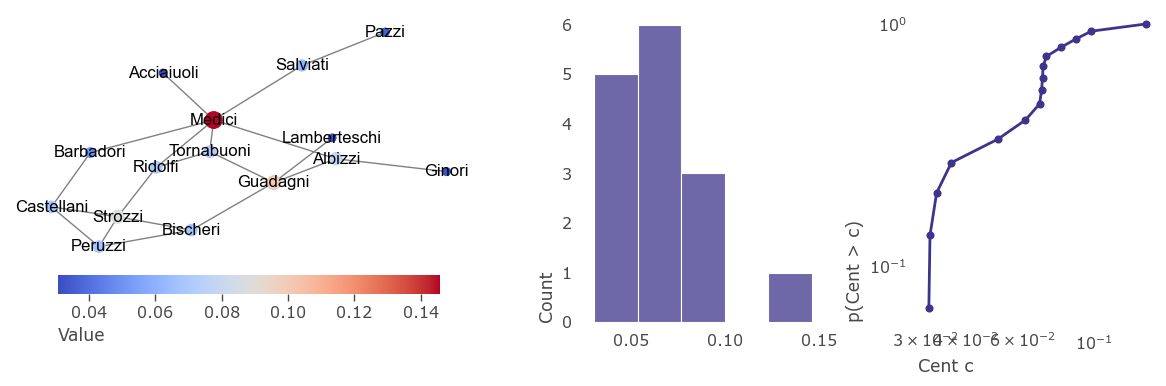

In [ ]:
# Pagerank centrality
cent = ...
cent = [cent[node] for node in G.nodes()]

plot_network_distribution(G, cent)

# Exercise 5: Centrality in real networks

Apply centrality measures to the Twitter and PPI networks.
- Who would you choose to spread news quickly? (assuming news are always passed on by the recipients)
- Who connects different communities?
- Who would you ask for information about who is most influential?
- Who would be best for spreading unreliable news? (assuming news are sometimes not passed on)

Calculate the top 10 nodes for each measure.

In [28]:
# Read edgelist
df = pd.read_csv(f"{path_data}/ic2s2_netsci_3.tsv", sep="\t")

In [29]:
# Convert to networkx
Gt = nx.from_pandas_edgelist(df, create_using=nx.DiGraph())
Gt.remove_edges_from(nx.selfloop_edges(Gt)) #remove self-edges

In [30]:
# Util function to extract top 10 nodes based on centrality measures
def extract_top_10(d_centrality):
    return pd.DataFrame.from_dict(d_centrality, orient="index").sort_values(by=0, ascending=False).head(10)

In [ ]:
#e.g. dc = extract_top_10(nx.degree_centrality(Gt))



,closeness,betweeness,hubs,pagerank
barabasi,0.504365,NaN,NaN,0.006019
netscisociety,0.495493,NaN,NaN,0.006048
tinaeliassi,0.493404,NaN,NaN,0.005638
IC2S2,0.492765,NaN,NaN,0.005311
tiagopeixoto,0.491491,0.029211,0.005837,NaN
NUnetsi,0.490698,NaN,NaN,NaN
alexvespi,0.490224,0.027481,NaN,0.005475
clauwa,0.489593,NaN,NaN,0.006440
cosnet_bifi,0.488806,NaN,0.004887,0.005534
manlius84,0.488649,0.046392,0.006836,0.005571


### Doing the analysis on the PPI network

In [32]:
# Read PPI network
path_network = f"{path_data}/ppi_network_prediction.graphml"
G = nx.read_graphml(path_network, node_type=int)
len(G.nodes()), len(G.edges())

# Add labels
mapping = {node: data['label'] for node, data in G.nodes(data=True) if 'label' in data}
G = nx.relabel_nodes(G, mapping)

In [33]:
cc = extract_top_10(nx.closeness_centrality(G)) #slow (all distances)
bc = extract_top_10(nx.betweenness_centrality(G)) #slow (all shortest paths)
ec = extract_top_10(nx.eigenvector_centrality(G))

df = pd.concat([cc,bc,ec], axis=1)
df.columns = ["closeness","betweeness","eigenvalue"]
df

#YLR291C: Involved in regulation of translational initiation. 
#Essential gene; conditional mutants are defective in autophagy and in Golgi localization of reporter proteins

,closeness,betweeness,eigenvalue
YLR291C,0.255540,0.278088,0.549200
YLR423C,0.225682,0.106286,0.168824
YPL070W,0.224041,NaN,0.229997
YCL028W,0.222497,0.054134,0.140249
YDR510W,0.219543,0.122370,NaN
YGL153W,0.218060,0.062695,NaN
YHR113W,0.217430,NaN,NaN
YFL039C,0.216045,NaN,NaN
YOL034W,0.215564,NaN,NaN
YLR245C,0.215017,NaN,0.128373


# Exercise 6: Eigenvector and Pagerank (advanced)

Learn how eigenvector and pagerank centrality can be computed using the power method.
- **Eigenvector:** Influence spreads to neighbors, repeated until convergence.
- **Pagerank:** Random walkers move through the network, with some probability of jumping anywhere.

Compare your manual results to NetworkX's built-in functions.

## 6.1 Eigenvector

For eigenvector centrality, each node has an influence of 1, that it is distributed to the neighbors. This process is done many times, until it converges.

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.48666426 0.32444284 0.64888568 0.16222142 0.32444284 0.32444284]


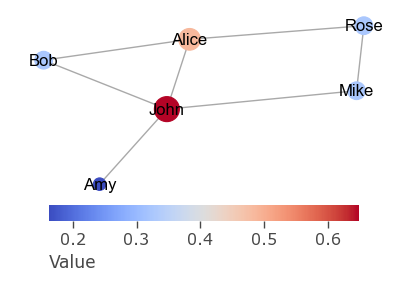

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.50196464 0.43921906 0.50196464 0.25098232 0.37647348 0.3137279 ]


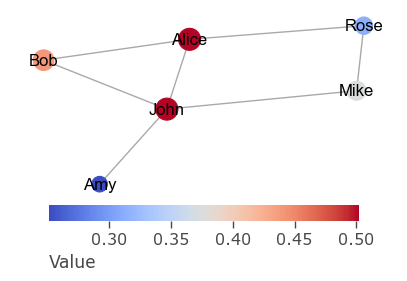

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.48365083 0.38692067 0.60456354 0.19346033 0.31437304 0.33855558]


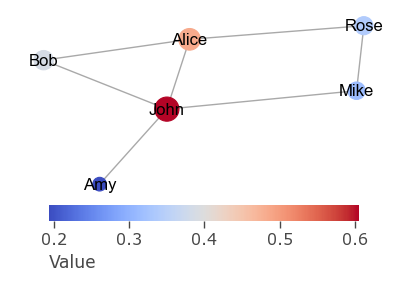

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.51212115 0.41900822 0.53074374 0.23278234 0.36314046 0.30727269]


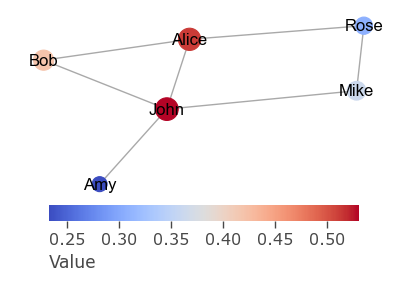

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.483843   0.40141049 0.58777964 0.20428927 0.322562   0.33689809]


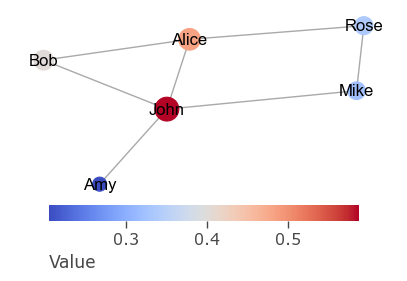

[('Alice', np.float64(0.49816568565363206)), ('Bob', np.float64(0.40845488054415907)), ('John', np.float64(0.5634381194270055)), ('Amy', np.float64(0.21678431148030036)), ('Mike', np.float64(0.3410115867353848)), ('Rose', np.float64(0.3228756816201712))]


{'Alice': 0.49816562620567956,
 'Bob': 0.4084543148167931,
 'John': 0.563437771403002,
 'Amy': 0.21678389847563684,
 'Mike': 0.3410123357350908,
 'Rose': 0.32287658256564244}

In [34]:
# Eigenvector centrality, manually
N = len(G_dir)
A = nx.to_numpy_array(G_undir)

# Start with everybody having 1 unit of influence
weight = np.ones(N)
for i in range(100):
    # spread influence to neighbors 
    weight = weight @ A

    # normalize uwing the geometrical mean
    weight = weight / np.sqrt(np.sum(weight**2))
    
    if i < 5:
        print(G_undir.nodes())
        print(weight)

        plot_network(G_undir, None, values = weight)
        plt.show()

# Compare with the results of networkx
print(list(zip(G_undir.nodes(), weight)))
nx.eigenvector_centrality(G_undir)

## 6.2 Pagerank
For pagerank centrality, we start with 1 random walker distributed over all nodes, from there, it gets distributed to the neighbors (1/k of the random walker go to each of the k neighbors). This process is done many times, until it converges.

In [35]:
# PAgerank centrality, manually
N = len(G_dir)
A = nx.to_numpy_array(G_dir)

## Calculate transition matrix (Row normalize matrix)
# construct diagonal inverse degree matrix
degree = A.sum(1)
D = np.diag(1./degree, 0)
A_hat = (D @ A)

# random walkers are spread out evenly
weight = np.ones(N)/N

for i in range(1000):
    # calculate where random walkers go next
    weight = weight @ (0.85*A_hat + 0.15/N)

# Compare results with networkx
print(list(zip(G_dir.nodes(), weight)))
nx.pagerank(G_dir)

[('Alice', np.float64(0.31535471331389314)), ('Bob', np.float64(0.2930515063168089)), ('John', np.float64(0.3059687803692869)), ('Amy', np.float64(0.024999999999999696)), ('Mike', np.float64(0.024999999999999696)), ('Rose', np.float64(0.03562499999999957))]


{'Alice': 0.3153534818017285,
 'Bob': 0.293052806246324,
 'John': 0.3059687119519481,
 'Amy': 0.025,
 'Mike': 0.025,
 'Rose': 0.035625000000000004}

## 6.3 Infinite random walker

A random walker ends up a fraction of time in each node proportional to the degree of the node

In [36]:
N = len(G_undir)
A = nx.to_numpy_array(G_undir)

## construct transition matrix (row normalised adjacency matrix)
# construct diagonal inverse degree matrix
degree = A.sum(1)
D = np.diag(1./degree, 0)
A_hat = (D @ A)

# it does not matter where the walker starts
weight = np.ones(N)/N

for i in range(1000):
    # calculate power
    weight = weight @ (A_hat)

# Normalize to match the scale of degree centrality 
weight = weight / np.sqrt(np.sum(weight**2))

# Compare to networkx
print(list(zip(G_undir.nodes(), weight)))
nx.degree_centrality(G_undir)

[('Alice', np.float64(0.4866642633922877)), ('Bob', np.float64(0.32444284226152514)), ('John', np.float64(0.6488856845230502)), ('Amy', np.float64(0.16222142113076257)), ('Mike', np.float64(0.32444284226152514)), ('Rose', np.float64(0.324442842261525))]


{'Alice': 0.6000000000000001,
 'Bob': 0.4,
 'John': 0.8,
 'Amy': 0.2,
 'Mike': 0.4,
 'Rose': 0.4}